# ---[Model Attempt]---

In [1]:
model_attempt = '5.1'

# 0. Model Overview

## General Notes

Trying to run through the original UNet model with my data. 

Uses data augmentation from ImageDataGenerator Keras function

## Hyperparameters/Variables

### Data Pre-Processing
* Image size: 512, 512
* Batch size: 4
* Epochs: 10
* Data augmentation: done through Keras ImageDataGenerator

### Test/Val/Train format and split
* Test/val split: 90/10

### Model Layers
* Activation function: Sigmoid

### Training
LOSS FUNCTION
* dice_coef_loss

OPTIMIZER
* Adam
* Learning rate: 0.00001 (1e-5)

METRICS
* Dice_coef
* IoU

CALLBACKS
* ModelCheckpoint
* LearningRateScheduler
* CSVLogger

# 1. Model

### [Import Packages - this was from previous model versions but leaving it just in case it is needed]

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, CSVLogger

Using TensorFlow backend.
/home/s188/OSHAW/project_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s188/OSHAW/project_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s188/OSHAW/project_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s188/OSHAW/project_env/lib/pytho

## i. Define data processing functions

Import required packages

In [4]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

Define the binary values for background and small bowel

In [5]:
BG = [0]
SB = [1]

Create the dictionary for these two classes

In [6]:
COLOR_DICT = np.array([BG, SB])

Define function for reshapping image and mask

In [7]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

Define function for generating the training data with augmentations

In [22]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

Define the function for generating the test data

In [8]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

Create a numpy function for the image and mask

In [24]:
def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%d*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

Createa function to visualise the data

In [9]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255


Save predicted results of test data in the same test folder

In [23]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

### Define your data generator
If you want to visualize your data augmentation result, set save_to_dir = your path

In [27]:
#if you don't want to do data augmentation, set data_gen_args as an empty dict.
#data_gen_args = dict()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'data/membrane/train','image','label',data_gen_args,save_to_dir = "data/membrane/train/aug")

### Visualise your data augmentation result

In [28]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


### Create .npy data
If your computer has enough memory, you can create npy files containing all your images and masks, and feed your DNN with them.

In [29]:
image_arr,mask_arr = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#np.save("data/image_arr.npy",image_arr)
#np.save("data/mask_arr.npy",mask_arr)

## ii. Create UNet Model

Import the required packages

In [31]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Define the UNet function

In [12]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Train your UNet with data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

Train the data 

In [33]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/s188/OSHAW/project_env/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`



Found 30 images belonging to 1 classes.
Epoch 1/5
Found 30 images belonging to 1 classes.
2000/2000 [==============================] - 4215s 2s/step - loss: 0.0357 - accuracy: 0.9910

Epoch 00001: loss improved from inf to 0.03567, saving model to unet_membrane.hdf5
Epoch 2/5
2000/2000 [==============================] - 4202s 2s/step - loss: 0.0238 - accuracy: 0.9967

Epoch 00002: loss improved from 0.03567 to 0.02377, saving model to unet_membrane.hdf5
Epoch 3/5
2000/2000 [==============================] - 4204s 2s/step - loss: 0.0231 - accuracy: 0.9960

Epoch 00003: loss improved from 0.02377 to 0.02314, saving model to unet_membrane.hdf5
Epoch 4/5
2000/2000 [==============================] - 4204s 2s/step - loss: 0.0188 - accuracy: 0.9974

Epoch 00004: loss improved from 0.02314 to 0.01879, saving model to unet_membrane.hdf5
Epoch 5/5
2000/2000 [==============================] - 4205s 2s/step - loss: 0.0157 - accuracy: 0.9981

Epoch 00005: loss improved from 0.01879 to 0.01575, sav

### Test your model and save predicted results

In [24]:
testGene = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)

/home/s188/OSHAW/project_env/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


30/30 [==============================] - 5s 161ms/step


/home/s188/OSHAW/project_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: data/membrane/test/0_predict.png is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/s188/OSHAW/project_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: data/membrane/test/1_predict.png is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/s188/OSHAW/project_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: data/membrane/test/2_predict.png is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/s188/OSHAW/project_env/lib/python3.6/site-packages/ipykernel_

Training Results

In [34]:
def plot_history(history, save=False, name=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    
    # Plot loss values
    ax1.plot(history['loss'])
    ax1.title.set_text('Model Loss')
    ax1.set_ylabel('Jaccard Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train'], loc='upper right')
    
    # Plot binary accuracy scores
    ax2.plot(history['accuracy'])
    ax2.title.set_text('Model Binary Accuracy')
    ax2.set_ylabel('Jaccard Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train'], loc='lower right')
    
    fig.tight_layout()
    fig.show()
    
    # If save is true, save the figure in figures folder with the name defined in function, otherwise just show the image
    if save==False:
        return
    else:
        fig.savefig(f'Figures/{name}.png')
        
    return

In [27]:
# Current training results
history = hist.history

NameError: name 'hist' is not defined

TypeError: string indices must be integers

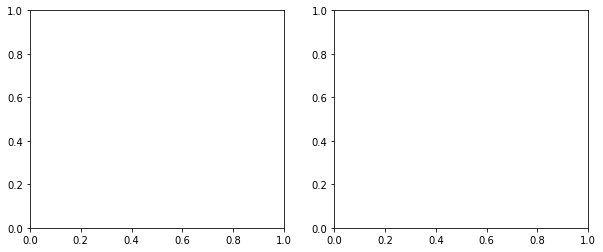

In [36]:
plot_history("unet_membrane.hdf5", save=False, name=None)

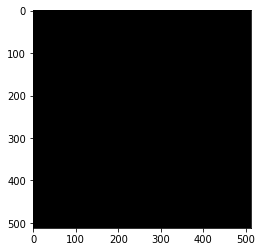

In [103]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

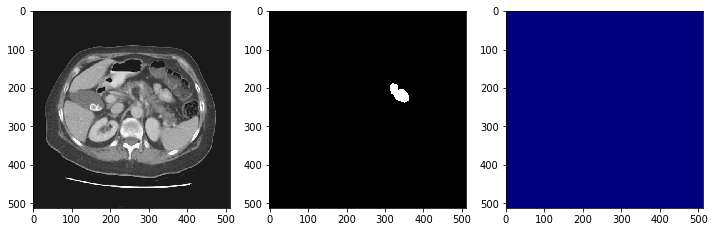

In [104]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gist_gray')
ax[1].imshow(y_val[0,:,:,0], cmap='gist_gray')
ax[2].imshow(y_hat[0,:,:,0], cmap='jet')